<a href="https://colab.research.google.com/github/RipHead/BYOP-2023/blob/main/Charecter_recognition_using_0ne_Hidden_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

# Downloading dataset with 62 charecters
dataset = EMNIST(root = 'data/', split = 'byclass', download = True, transform = transforms.ToTensor())

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [ ]:
# dataset downloaded and images are converted to tensors
len(dataset)


697932

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split



following standard procedure to load data/ split the data into different batches

In [ ]:
train_ds, val_ds = random_split(dataset, [600000, 97932])
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle = True )
val_dl = DataLoader(val_ds, batch_size)

In [ ]:
in_size = 28*28
out_size = 62



In [ ]:
def accuracy(out, labels):
  _, preds = torch.max(out, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item()/len(labels))

creating model class with 1 hidden layer

In [ ]:
class MyModel(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.layer1 = nn.Linear(in_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, out_size)
  def forward(self, xb):
    xb = xb.view(xb.size(0), in_size)
    out1 = self.layer1(xb)
    out2 = F.relu(out1)
    out3 = self.layer2(out2)
    return out3
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    acc = accuracy(out, labels)
    loss = F.cross_entropy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}
  def validation_epoch_end(self, output):
    batch_losses = [x['val_loss'] for x in output]
    batch_accs = [x['val_acc'] for x in output]
    epoch_acc = torch.stack(batch_accs).mean()
    epoch_loss = torch.stack(batch_losses).mean()
    return {'val_acc': epoch_acc.item(), 'val_loss': epoch_loss.item()}
  def epoch_end(self, epoch, result):
    print("Epoch: {}, acc==>{}, loss==>{}".format(epoch+1, result['val_acc'], result['val_loss']))
  
model = MyModel(124)

In [ ]:
def evaluate(model, val_dl):
  output = [model.validation_step(batch) for batch in  val_dl]
  return model.validation_epoch_end(output)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def fit(num_epochs, lr, model, train_dl, val_dl, opt_func = torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  x = []
  y = []
  for epoch in range(num_epochs):
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_dl)
    model.epoch_end(epoch, result)
    x.append(epoch+1)
    y.append(result['val_acc']*100)
  plt.plot(x,y)
  plt.xlabel("epochs")
  plt.ylabel("accuracy in %")
  plt.show()


Epoch: 1, acc==>0.4176543354988098, loss==>2.8104500770568848
Epoch: 2, acc==>0.49652552604675293, loss==>2.1698522567749023
Epoch: 3, acc==>0.5531798601150513, loss==>1.845292568206787
Epoch: 4, acc==>0.587182343006134, loss==>1.6509335041046143
Epoch: 5, acc==>0.6075408458709717, loss==>1.5239187479019165
Epoch: 6, acc==>0.6218673586845398, loss==>1.4349976778030396
Epoch: 7, acc==>0.6350816488265991, loss==>1.3692940473556519
Epoch: 8, acc==>0.6446938514709473, loss==>1.3189949989318848
Epoch: 9, acc==>0.6531632542610168, loss==>1.278705358505249
Epoch: 10, acc==>0.6608992218971252, loss==>1.2461556196212769


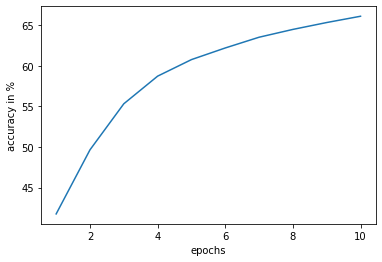

In [ ]:
fit(10, 0.001, model, train_dl, val_dl)